In [ ]:
!pip install catboost
!pip install lightgbm
!pip install holidays

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,MinMaxScaler,StandardScaler,Normalizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.ensemble import AdaBoostClassifier,AdaBoostRegressor
from sklearn.naive_bayes import GaussianNB,BernoulliNB
from sklearn.svm import SVC,SVR
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis#LDA降维
from sklearn import metrics
import warnings
from catboost import CatBoostRegressor
from sklearn.decomposition import PCA
warnings.filterwarnings("ignore")
import holidays
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor

from xgboost import XGBRegressor
import datetime

# Load HK Calendar
hk_holiday = holidays.HK()

# Load Training Data

In [ ]:
train_data = pd.read_csv("./drive/MyDrive/Kaggle_5001/train.csv")

In [ ]:
train_data['date']= pd.to_datetime(train_data['date'], format='%d/%m/%Y %H:%M')

train_data['date'] = pd.to_datetime(train_data['date'])
## year/month/day/hour/minute/second
train_data['year'] = train_data['date'].dt.year.astype('int')
train_data['month'] = train_data['date'].dt.month
train_data['day'] = train_data['date'].dt.day
train_data['hour'] = train_data['date'].dt.hour
## week
train_data['week'] = train_data['date'].dt.dayofweek
## quarter
train_data['quarter'] = train_data['date'].dt.quarter
## day of the year
train_data['day_of_year'] = train_data['date'].dt.dayofyear
## week of the year
train_data['week_of_year'] = train_data['date'].dt.weekofyear
## month_day
train_data['month_day'] = train_data['month'].astype('string') + train_data['day'].astype('string')
train_data['month_day'] = train_data['month_day'].astype('int')

## drop date
train_data.drop(columns = [ 'month_day'], inplace = True)

train_data.head()

,id,date,speed,year,month,day,hour,week,quarter,day_of_year,week_of_year
0,0,2017-01-01 00:00:00,43.002930,2017,1,1,0,6,1,1,52
1,1,2017-01-01 01:00:00,46.118696,2017,1,1,1,6,1,1,52
2,2,2017-01-01 02:00:00,44.294158,2017,1,1,2,6,1,1,52
3,3,2017-01-01 03:00:00,41.067468,2017,1,1,3,6,1,1,52
4,4,2017-01-01 04:00:00,46.448653,2017,1,1,4,6,1,1,52


In [ ]:
train_data['is_holiday'] = train_data['date'].map(lambda x: ((datetime.date(x.year, x.month, x.day)) in hk_holiday ))
train_data['is_holiday'] = train_data['is_holiday'].replace({False:0, True:1})

In [ ]:
train_data['is_weekend'] = train_data['week'].map(lambda x: x == 6 or x == 5)
train_data['is_weekend'] = train_data['is_weekend'].replace({False:0, True:1})

Load Weather Data from 'https://www.hko.gov.hk/en/wxinfo/pastwx/metob'

In [ ]:
weather=pd.read_csv("/content/drive/MyDrive/weather.csv")
weather.drop("Unnamed: 0",axis=1,inplace=True)
weather['year'].apply(lambda t:int(t))
weather['month'].apply(lambda t:int(t))
weather['day'].apply(lambda t:int(t))
weather.drop(['year','month','day'],axis=1)

# Process Date 
def toDate(x):
    return datetime.datetime(x[0],x[1],x[2]).date()

weather['date_time']=weather.apply(toDate,axis=1)

# Get Average Temperature
weather['Avg_tmp'] = (weather['Max_tmp'] + weather['Min_tmp'])

# Transform RainFall into Available Input
weather['RainFall']=weather['TRainfall(mm)'].apply(lambda x:0 if x in ['-','Trace'] else x)

weather.head()

,year,month,day,Max_tmp,Min_tmp,Cloud,TRainfall(mm),WindDirect,WindSpeed,date_time,Avg_tmp,RainFall
0,2017,1,1,20.8,18.4,72,-,60,34.2,2017-01-01,39.2,0
1,2017,1,2,23.3,18.4,28,-,70,17.7,2017-01-02,41.7,0
2,2017,1,3,21.3,18.9,56,-,70,26.1,2017-01-03,40.2,0
3,2017,1,4,21.7,18.7,51,-,70,27.7,2017-01-04,40.4,0
4,2017,1,5,23.4,18.9,61,-,40,14.3,2017-01-05,42.3,0


In [ ]:
train_data['date_time']=train_data['date'].apply(lambda x:x.date())

train_data=pd.merge(train_data[['speed','year','month','day','hour', 'week', 'day_of_year', 'week_of_year', 'is_holiday', 'is_weekend', 'quarter','date_time']],
              weather[['Max_tmp','Min_tmp','Avg_tmp', 'Cloud','RainFall','WindDirect','WindSpeed','date_time']],on='date_time',how='left')

train_data.head()

,speed,year,month,day,hour,week,day_of_year,week_of_year,is_holiday,is_weekend,quarter,date_time,Max_tmp,Min_tmp,Avg_tmp,Cloud,RainFall,WindDirect,WindSpeed
0,43.002930,2017,1,1,0,6,1,52,0,1,1,2017-01-01,20.8,18.4,39.2,72,0,60,34.2
1,46.118696,2017,1,1,1,6,1,52,0,1,1,2017-01-01,20.8,18.4,39.2,72,0,60,34.2
2,44.294158,2017,1,1,2,6,1,52,0,1,1,2017-01-01,20.8,18.4,39.2,72,0,60,34.2
3,41.067468,2017,1,1,3,6,1,52,0,1,1,2017-01-01,20.8,18.4,39.2,72,0,60,34.2
4,46.448653,2017,1,1,4,6,1,52,0,1,1,2017-01-01,20.8,18.4,39.2,72,0,60,34.2


In [ ]:
train_data['RainFall'] = train_data['RainFall'].astype('float')

In [ ]:
train_data = train_data.drop(['date_time'],axis=1)
train_data.head()

,speed,year,month,day,hour,week,day_of_year,week_of_year,is_holiday,is_weekend,quarter,Max_tmp,Min_tmp,Avg_tmp,Cloud,RainFall,WindDirect,WindSpeed
0,43.002930,2017,1,1,0,6,1,52,0,1,1,20.8,18.4,39.2,72,0.0,60,34.2
1,46.118696,2017,1,1,1,6,1,52,0,1,1,20.8,18.4,39.2,72,0.0,60,34.2
2,44.294158,2017,1,1,2,6,1,52,0,1,1,20.8,18.4,39.2,72,0.0,60,34.2
3,41.067468,2017,1,1,3,6,1,52,0,1,1,20.8,18.4,39.2,72,0.0,60,34.2
4,46.448653,2017,1,1,4,6,1,52,0,1,1,20.8,18.4,39.2,72,0.0,60,34.2


In [ ]:
train_data.head()

,speed,year,month,day,hour,week,day_of_year,week_of_year,is_holiday,is_weekend,quarter,Max_tmp,Min_tmp,Avg_tmp,Cloud,RainFall,WindDirect,WindSpeed
0,43.002930,2017,1,1,0,6,1,52,0,1,1,20.8,18.4,39.2,72,0.0,60,34.2
1,46.118696,2017,1,1,1,6,1,52,0,1,1,20.8,18.4,39.2,72,0.0,60,34.2
2,44.294158,2017,1,1,2,6,1,52,0,1,1,20.8,18.4,39.2,72,0.0,60,34.2
3,41.067468,2017,1,1,3,6,1,52,0,1,1,20.8,18.4,39.2,72,0.0,60,34.2
4,46.448653,2017,1,1,4,6,1,52,0,1,1,20.8,18.4,39.2,72,0.0,60,34.2


# Take a look at new dataset

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


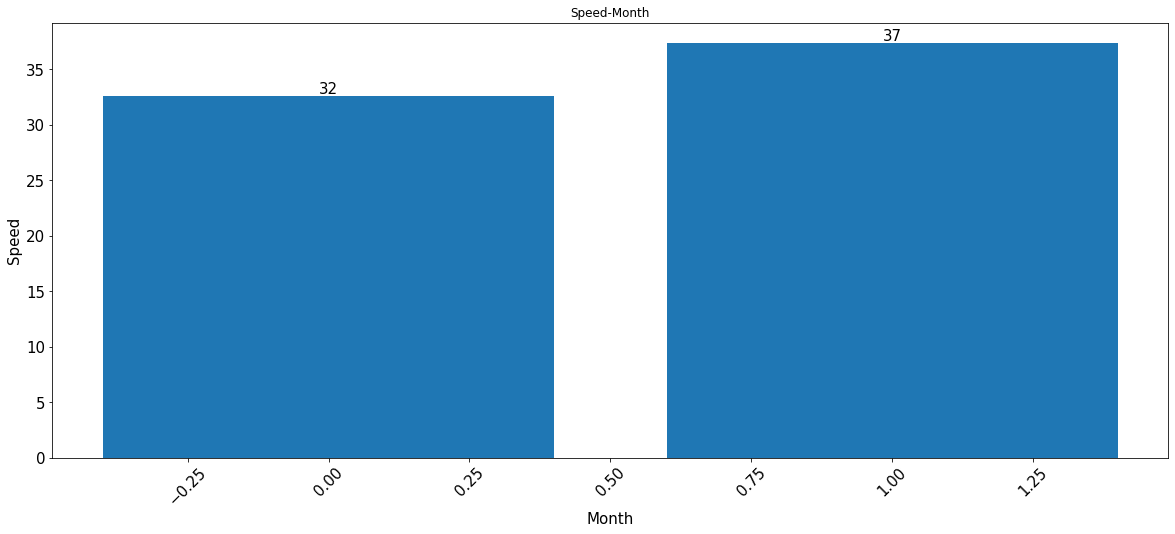

In [ ]:
#amenities 分布
import re
plt.rcParams['font.sans-serif']=['SimHei']
#获取每个地区平均价格，并排序
df_amenities=train_data.groupby(by="is_holiday")["speed"].mean().sort_values(ascending=False)
#绘图
plt.figure(figsize=(20,8))
bar1=plt.bar(df_amenities.index,df_amenities.values)
plt.xticks(rotation=45,size=15)
plt.yticks(size=15)
plt.title("Speed-Month")
plt.xlabel("Month",size=15)
plt.ylabel("Speed",size=15)
for i in bar1:
    plt.text(i.get_x()+i.get_width()/2,i.get_height(),"%d"%int(i.get_height()),ha="center",va="bottom",fontsize=15)
plt.show()

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


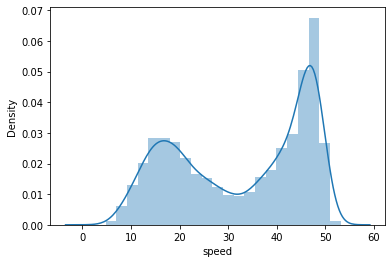

In [ ]:
sns.distplot(train_data[train_data['speed']<=100000]["speed"])
plt.show()

# Load Testing Data

In [ ]:
#get test data

test_data = pd.read_csv("./drive/MyDrive/Kaggle_5001/test.csv")

test_data.dropna(inplace=True)
test_data.reset_index(drop=True, inplace=True)
test_data.head()

,id,date
0,0,1/1/2018 2:00
1,1,1/1/2018 5:00
2,2,1/1/2018 7:00
3,3,1/1/2018 8:00
4,4,1/1/2018 10:00


In [ ]:
test_data['date']= pd.to_datetime(test_data['date'], format='%d/%m/%Y %H:%M')
test_data['date'] = pd.to_datetime(test_data['date'])

## year/month/day/hour/minute/second
test_data['year'] = test_data['date'].dt.year.astype('int')
test_data['month'] = test_data['date'].dt.month
test_data['day'] = test_data['date'].dt.day
test_data['hour'] = test_data['date'].dt.hour
# train_data['minute'] = train_data['date'].dt.minute
# train_data['second'] = train_data['date'].dt.second
## week
test_data['week'] = test_data['date'].dt.dayofweek
## quarter
test_data['quarter'] = test_data['date'].dt.quarter
## day of the year
test_data['day_of_year'] = test_data['date'].dt.dayofyear

## week of the year
test_data['week_of_year'] = test_data['date'].dt.weekofyear

## month_day
test_data['month_day'] = test_data['month'].astype('string') + test_data['day'].astype('string')
test_data['month_day'] = test_data['month_day'].astype('int')

#holiday and weekend
test_data['is_holiday_weekend'] = test_data['date'].map(lambda x: (datetime.date(x.year, x.month, x.day) in hk_holiday) or x.dayofweek == 6 or x.dayofweek == 5)

## is Holiday
test_data['is_holiday'] = test_data['date'].map(lambda x: (datetime.date(x.year, x.month, x.day) in hk_holiday))


# ## is Weekend
test_data['is_weekend'] = test_data['week'].map(lambda x: x == 6 or x == 5)
test_data['is_weekend'] = test_data['is_weekend'].replace({False:0, True:1})


## drop date
test_data.drop(columns = ['month_day'], inplace = True)

test_data['is_holiday'] = test_data['is_holiday'].replace({False:0, True:1})

test_data.head()

,id,date,year,month,day,hour,week,quarter,day_of_year,week_of_year,is_holiday_weekend,is_holiday,is_weekend
0,0,2018-01-01 02:00:00,2018,1,1,2,0,1,1,1,True,1,0
1,1,2018-01-01 05:00:00,2018,1,1,5,0,1,1,1,True,1,0
2,2,2018-01-01 07:00:00,2018,1,1,7,0,1,1,1,True,1,0
3,3,2018-01-01 08:00:00,2018,1,1,8,0,1,1,1,True,1,0
4,4,2018-01-01 10:00:00,2018,1,1,10,0,1,1,1,True,1,0


In [ ]:
test_data['date_time']=test_data['date'].apply(lambda x:x.date())

test_data=pd.merge(test_data[['year','month','day','hour', 'week', 'day_of_year', 'week_of_year', 'is_holiday', 'is_weekend', 'quarter','date_time']],
              weather[['Max_tmp','Min_tmp','Avg_tmp', 'Cloud','RainFall','WindDirect','WindSpeed','date_time']],on='date_time',how='left')

test_data.head()

,year,month,day,hour,week,day_of_year,week_of_year,is_holiday,is_weekend,quarter,date_time,Max_tmp,Min_tmp,Avg_tmp,Cloud,RainFall,WindDirect,WindSpeed
0,2018,1,1,2,0,1,1,1,0,1,2018-01-01,19.0,16.3,35.3,75,0,70,28.4
1,2018,1,1,5,0,1,1,1,0,1,2018-01-01,19.0,16.3,35.3,75,0,70,28.4
2,2018,1,1,7,0,1,1,1,0,1,2018-01-01,19.0,16.3,35.3,75,0,70,28.4
3,2018,1,1,8,0,1,1,1,0,1,2018-01-01,19.0,16.3,35.3,75,0,70,28.4
4,2018,1,1,10,0,1,1,1,0,1,2018-01-01,19.0,16.3,35.3,75,0,70,28.4


In [ ]:
test_data['RainFall'] = test_data['RainFall'].astype('float')


In [ ]:
test_data = test_data.drop(['date_time'],axis=1)
test_data.head()

,year,month,day,hour,week,day_of_year,week_of_year,is_holiday,is_weekend,quarter,Max_tmp,Min_tmp,Avg_tmp,Cloud,RainFall,WindDirect,WindSpeed
0,2018,1,1,2,0,1,1,1,0,1,19.0,16.3,35.3,75,0.0,70,28.4
1,2018,1,1,5,0,1,1,1,0,1,19.0,16.3,35.3,75,0.0,70,28.4
2,2018,1,1,7,0,1,1,1,0,1,19.0,16.3,35.3,75,0.0,70,28.4
3,2018,1,1,8,0,1,1,1,0,1,19.0,16.3,35.3,75,0.0,70,28.4
4,2018,1,1,10,0,1,1,1,0,1,19.0,16.3,35.3,75,0.0,70,28.4


In [ ]:
train_data.head()

,speed,year,month,day,hour,week,day_of_year,week_of_year,is_holiday,is_weekend,quarter,Max_tmp,Min_tmp,Avg_tmp,Cloud,RainFall,WindDirect,WindSpeed
0,43.002930,2017,1,1,0,6,1,52,0,1,1,20.8,18.4,39.2,72,0.0,60,34.2
1,46.118696,2017,1,1,1,6,1,52,0,1,1,20.8,18.4,39.2,72,0.0,60,34.2
2,44.294158,2017,1,1,2,6,1,52,0,1,1,20.8,18.4,39.2,72,0.0,60,34.2
3,41.067468,2017,1,1,3,6,1,52,0,1,1,20.8,18.4,39.2,72,0.0,60,34.2
4,46.448653,2017,1,1,4,6,1,52,0,1,1,20.8,18.4,39.2,72,0.0,60,34.2


# Feature and label Split

In [ ]:
from sklearn.model_selection import train_test_split
from math import sqrt
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier,XGBRegressor
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn import tree
import numpy as np
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.constraints import non_neg

import matplotlib.pyplot as plot  

In [ ]:
# change the order randomly
## use a fixed seed
train_data_ranp = train_data
np.random.seed(123)
new_index = np.random.permutation(train_data_ranp.index)
train_data_ranp = train_data_ranp.reindex(new_index)


In [ ]:
X_train = train_data_ranp.drop(columns=["speed"])
Y_train = train_data_ranp["speed"]
X_test = test_data#.drop(columns = ["id"])
print(X_train)
print(X_test)

       year  month  day  hour  ...  Cloud  RainFall  WindDirect  WindSpeed
5603   2017      8   22    21  ...     74       2.0          20       14.9
11926  2018      8    3    15  ...     86       0.0         230       22.1
8047   2017     12    2    17  ...     65       0.0         360       23.5
11309  2018      6   22    16  ...     87      32.9         180       19.2
7738   2017     11   19    20  ...     88       1.0          60       41.5
...     ...    ...  ...   ...  ...    ...       ...         ...        ...
5218   2017      8    6    20  ...     61       0.0         240       19.1
12252  2018      8   26    12  ...     86      80.2         360        9.5
1346   2017      2   26    11  ...     88       1.4         360       21.7
11646  2018      7   16     5  ...     80       5.8          70       41.8
3582   2017      5   30    15  ...     70       0.0          80       18.5

[14006 rows x 17 columns]
      year  month  day  hour  ...  Cloud  RainFall  WindDirect  WindSpeed

In [ ]:
from sklearn.model_selection import train_test_split
# train_data.head()
x = train_data.iloc[:, 1:]
y = train_data['speed']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)
print(x_train)
print(x_test)

       year  month  day  hour  ...  Cloud  RainFall  WindDirect  WindSpeed
3866   2017      6   11    11  ...     47       0.0         130       10.8
3705   2017      6    4    18  ...     88       0.0         210       22.9
239    2017      1   10    23  ...     72       0.0          70       36.6
11504  2018      7    6    16  ...     88       5.0         190       20.0
6138   2017      9   14     4  ...     76       0.0          70       36.0
...     ...    ...  ...   ...  ...    ...       ...         ...        ...
8737   2017     12   31    11  ...     33       0.0         360       27.4
3480   2017      5   26     9  ...     72       0.0          40       17.8
6978   2017     10   19     4  ...     70       0.0         350       33.5
5977   2017      9    7    11  ...     86       1.8         280        5.2
11684  2018      7   19     1  ...     85      17.3          80       36.5

[12605 rows x 17 columns]
       year  month  day  hour  ...  Cloud  RainFall  WindDirect  WindSpee

# Modeling

Have tried several different models as shown below: RF, Catboost, LGBM, XGB. 


The final result is generated using Catboost cause it got highest score. 

In [ ]:
#################### RF ####################
# est = RandomForestRegressor(max_depth=200, random_state=0,
#     n_estimators=10000, n_jobs=4)

#################### Catboost ####################

from sklearn.metrics import mean_squared_error as mse
est = cb.CatBoostRegressor(iterations=2000,
                             learning_rate=0.05,
                             depth=10,
                             eval_metric='RMSE',
                             random_seed = 23,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 75,
                             od_wait=100)
# 3.6667050980985887 for cb
# 3.6549796195270057
# 3.621991962596926
# 3.2516671753392457

#################### LGBM ####################

# est = LGBMRegressor(num_leaves = 70, learning_rate=0.04, n_estimators = 2000, max_depth = -1, 
#                     subsample_for_bin=200000, objective=None, 
#                     class_weight=None, min_split_gain=0.0, 
#                     min_child_weight=0.001, min_child_samples=20, subsample=1.0) 
#3.741596780067727
# remove is_holiday_weekend : 3.7195629315016516
# add week of the year:  3.6822495483551636
# is weekend only sunday: 3.608168350759234
# add cycle: 3.50729807432632
# 3.472395708504071
# 3.319701730866844

# 12.164095993515405

#################### XGBoost ####################

# est = XGBRegressor(n_estimators=1000, learning_rate = 0.05, max_depth = 12, gamma = 0.1, subsample = 0.6,
#              reg_alpha = 3, reg_lambda = 3)
# est = GradientBoostingRegressor(learning_rate=0.2, n_estimators=2000, 
#                                 subsample=1.0, criterion='friedman_mse',
#                                 min_samples_split=2, min_samples_leaf=1, 
#                                 min_weight_fraction_leaf=0.0, max_depth=5)
# 3.3237225631179244
# 3.3317490768413602
# 3.2618047332973323
est.fit(X_train, Y_train)
# est.fit(x_train, y_train)

# y_pred = est.predict(x_test)
# # loss function
# def rmse(y, y_pred):
#     return np.sqrt(np.mean((y_pred - y)**2))


# rmse(y_pred, y_test)

# check the mse loss of the best model
# y_pred = est.predict(x_test)
# loss = sum((y_pred - y_test)**2)/len(y_pred)
# print(loss)
# pred_y = est.predict(x_test)
# MSE = mse(pred_y,y_test)
# print("MSE:" + str(MSE))
# RMSE=sqrt(MSE)
# print("RMSE:" + str(RMSE))

0:	learn: 13.0111505	total: 28.3ms	remaining: 56.6s
75:	learn: 3.7158349	total: 2.01s	remaining: 50.9s
150:	learn: 3.2892896	total: 4.01s	remaining: 49.2s
225:	learn: 3.0395329	total: 6s	remaining: 47.1s
300:	learn: 2.8681147	total: 7.98s	remaining: 45.1s
375:	learn: 2.7280342	total: 9.96s	remaining: 43s
450:	learn: 2.6143141	total: 11.9s	remaining: 41s
525:	learn: 2.5225319	total: 14s	remaining: 39.3s
600:	learn: 2.4291411	total: 16.1s	remaining: 37.5s
675:	learn: 2.3560436	total: 18.1s	remaining: 35.5s
750:	learn: 2.2833010	total: 20.2s	remaining: 33.6s
825:	learn: 2.2177273	total: 22.1s	remaining: 31.5s
900:	learn: 2.1586918	total: 24.1s	remaining: 29.4s
975:	learn: 2.1019850	total: 26.1s	remaining: 27.4s
1050:	learn: 2.0511010	total: 28s	remaining: 25.3s
1125:	learn: 1.9982382	total: 30s	remaining: 23.3s
1200:	learn: 1.9504336	total: 32s	remaining: 21.3s
1275:	learn: 1.9046926	total: 34s	remaining: 19.3s
1350:	learn: 1.8643259	total: 36s	remaining: 17.3s
1425:	learn: 1.8226172	tota

# **Predict**

In [ ]:
test = est.predict(X_test)

from pandas.core.frame import DataFrame

submit = {"speed": test}
submit_data = DataFrame(submit)
# y_test = np.array(y_test)
submit_data["speed"].to_list()
# loss = sum(abs(submit_data['speed'] - y_test))
# print(loss/len(y_test))

[48.19207262754432,
 47.900338614401335,
 40.31302993906221,
 31.427098144182743,
 40.90982924917031,
 26.651042789835547,
 20.1385029238697,
 49.68651355439682,
 48.3470451230718,
 31.9010746849607,
 30.34158898880834,
 24.482780917042383,
 25.700598016833176,
 25.34876729367953,
 28.546776881957538,
 41.6710852852871,
 43.34631705735391,
 48.35735608211441,
 48.323669099953115,
 48.52056504036899,
 46.53378916949948,
 43.80834193315018,
 19.83885794975903,
 29.406271785053523,
 25.783459541827256,
 19.945408302343793,
 21.062438238047267,
 19.9286741054516,
 16.182536234433652,
 12.29283641312125,
 25.58414921167251,
 47.41534679581981,
 49.4335389721882,
 28.486639650450318,
 27.99777440434571,
 24.082867824054027,
 19.672890527567922,
 19.87042781718057,
 45.94199416782169,
 40.092626514643726,
 44.754713721477785,
 48.10513393270704,
 49.06730971042285,
 44.318336312570665,
 19.551135298447342,
 18.218686909298462,
 18.06464562495585,
 9.78119757005372,
 44.21386604081661,
 48.449

In [ ]:
submit_data.to_csv("./final26.csv", index_label="id")

In [ ]:
train_res = pd.read_csv('./final26.csv')
print(train_res)

        id      speed
0        0  48.192073
1        1  47.900339
2        2  40.313030
3        3  31.427098
4        4  40.909829
...    ...        ...
3499  3499  12.526108
3500  3500  26.484006
3501  3501  45.692301
3502  3502  39.477351
3503  3503  42.710120

[3504 rows x 2 columns]
